In [ ]:
import os

#GENERAL CONFIG
LABELS_FONTSIZE = 18
TICKS_FONTSIZE = 16
TITLE_FONTSIZE = 18
LEGEND_FONTSIZE = 16

FRAME_TYPE = 'all' #all, i or p

ANCHOR_PATH = "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/anchor.json"

TESTS_PATHS = [
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_-5.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_-3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_-1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-9_interval_5.json",
    
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_-5.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_-3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_-1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-6_interval_5.json",

    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_-5.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_-3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_-1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_1.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_3.json",
    "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/interval_noise_analysis/noise_amp_10E-3_interval_5.json",

    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e1.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e2.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e3.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e4.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e5.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e6.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e7.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e8.json",
    # "/home/ruhan/hwsigmoid_lascas2026/coding_outputs/noise_analysis/noise_1e9.json",
]


TESTS_LABELS = [os.path.splitext(os.path.basename(p))[0] for p in TESTS_PATHS]


print(TESTS_LABELS)

DATASET = "UVG"

['noise_1e1', 'noise_1e2', 'noise_1e3', 'noise_1e4', 'noise_1e5', 'noise_1e6', 'noise_1e7', 'noise_1e8', 'noise_1e9']


In [24]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from bjontegaard import bd_rate, bd_psnr


def extract_by_sequence(data, frame_type):
    results = defaultdict(lambda: defaultdict(dict))
    for dataset, sequences in data.items():
        for seq, entries in sequences.items():
            for key, v in entries.items():
                rate_idx = v["rate_idx"]
                bpp = v[f"ave_{frame_type}_frame_bpp"]
                psnr = v[f"ave_{frame_type}_frame_psnr"]
                results[dataset][seq][rate_idx] = (bpp, psnr)
    return results

In [25]:
# -*- coding: utf-8 -*-, 32
# Lê o JSON no formato mostrado e transforma em um DataFrame "tidy".
# Funciona tanto recebendo um caminho de arquivo quanto uma string JSON.

from pathlib import Path
import json
import pandas as pd

def metrics_json_to_df(src):
    """
    src: caminho para arquivo .json OU string JSON.
    retorna: pandas.DataFrame com colunas planas (dataset, sequence, rate_idx, ...).
    """
    # 1) Carregar o JSON
    if isinstance(src, (str, Path)) and Path(str(src)).exists():
        with open(src, "r", encoding="utf-8") as f:
            data = json.load(f)
    elif isinstance(src, (str, bytes)) and str(src).lstrip().startswith("{"):
        data = json.loads(src)
    else:
        raise ValueError("Passe um caminho existente para o arquivo .json ou uma string JSON válida.")

    # 2) Percorrer a estrutura e coletar linhas
    rows = []
    for dataset_name, sequences in data.items():                 # ex.: "UVG", "HEVC_B", ...
        for seq_name, rates in sequences.items():                # ex.: "Beauty_1920x1080_120", ...
            for rate_key, metrics in rates.items():              # ex.: "000", "001", ...
                # Copiar o dict de métricas e adicionar chaves de contexto
                m = dict(metrics)  # copia
                m["dataset"]  = dataset_name
                m["sequence"] = seq_name

                # rate_idx já vem no JSON como inteiro; o rate_key é string ("000", ...).
                # Mantemos o 'rate_idx' como coluna principal (int) e também guardamos o rótulo textual, se útil.
                m["rate_key"] = rate_key
                # opcional: garantir consistência (não é obrigatório)
                if "rate_idx" not in m:
                    # se não existir, derivar do rótulo textual
                    try:
                        m["rate_idx"] = int(rate_key)
                    except Exception:
                        pass

                # Evitar duplicatas redundantes (o JSON já inclui ds_name/seq internos)
                m.pop("ds_name", None)
                m.pop("seq", None)

                rows.append(m)

    # 3) Criar DataFrame
    df = pd.DataFrame.from_records(rows)

    # 4) Tipos e ordenação (opcional)
    if "rate_idx" in df.columns:
        df["rate_idx"] = pd.to_numeric(df["rate_idx"])
        df = df.sort_values(["dataset", "sequence", "rate_idx"]).reset_index(drop=True)
    else:
        df = df.sort_values(["dataset", "sequence", "rate_key"]).reset_index(drop=True)

    return df




In [26]:
df_results = metrics_json_to_df(ANCHOR_PATH)
df_results["experiment"] = "anchor"

for test in TESTS_PATHS:
    test_df = metrics_json_to_df(test)
    test_df["experiment"] = test.split("/")[-1].replace(".json", "")
    df_results = pd.concat([df_results, test_df], ignore_index=True)

# df_results.columns

In [27]:
# 1) Lista de experiments únicos
df = df_results

experiments = df['experiment'].dropna().unique()
print("Experiments únicos:", experiments)

# 2) Para cada experiment, lista datasets únicos
#    (ignorando NaN em 'dataset')
exp_to_datasets = (
    df.dropna(subset=['experiment', 'dataset'])
      .groupby('experiment')['dataset']
      .unique()
      .sort_index()
)

print("\nDatasets por experiment:")
for exp, dsets in exp_to_datasets.items():
    print(f"  {exp}: {sorted(map(str, dsets))}")

# 3) Datasets que aparecem em TODOS os experiments
#    (forma 1: interseção de conjuntos)
if len(exp_to_datasets) == 0:
    common_datasets = set()
else:
    common_datasets = set(exp_to_datasets.iloc[0])
    for dsets in exp_to_datasets.iloc[1:]:
        common_datasets &= set(dsets)

print("\nDatasets presentes em TODOS os experiments:", sorted(map(str, common_datasets)))

# (alternativa equivalente, concisa)
# total_exps = df['experiment'].dropna().nunique()
# counts = (df.dropna(subset=['experiment','dataset'])
#             .groupby('dataset')['experiment'].nunique())
# common_datasets_alt = set(counts[counts == total_exps].index)

# Filtrar o df
df_filtered = df[df['dataset'].isin(common_datasets)].copy()

# (Opcional) ver o que foi removido
all_datasets = set(df['dataset'].dropna().unique())
removed = sorted(map(str, all_datasets - common_datasets))
print("\nDatasets removidos:", removed)

# Resultado final:
# df_filtered contém apenas linhas cujos 'dataset' aparecem em todos os 'experiment'
df_results = df_filtered

Experiments únicos: ['anchor' 'noise_1e1' 'noise_1e2' 'noise_1e3' 'noise_1e4' 'noise_1e5'
 'noise_1e6' 'noise_1e7' 'noise_1e8' 'noise_1e9']

Datasets por experiment:
  anchor: ['UVG']
  noise_1e1: ['UVG']
  noise_1e2: ['UVG']
  noise_1e3: ['UVG']
  noise_1e4: ['UVG']
  noise_1e5: ['UVG']
  noise_1e6: ['UVG']
  noise_1e7: ['UVG']
  noise_1e8: ['UVG']
  noise_1e9: ['UVG']

Datasets presentes em TODOS os experiments: ['UVG']

Datasets removidos: []


In [28]:
import pandas as pd
import numpy as np

def averages_by_rate(df, experiment=None, dataset=None, frame_type='all'):
    """
    Filters the DataFrame and returns three NumPy arrays:
      - rate_vals : rate values (sorted)
      - bpp_means    : average bpp for each quality
      - psnr_means   : average psnr for each quality

    Any parameter can be set to None to skip filtering by that field.
    """
    cond = pd.Series(True, index=df.index)

    
    
    if dataset is not None:
        cond &= (df['dataset'] == dataset)
    cond &= (df['experiment'] == experiment)

    df_filtered = df[cond]

    if df_filtered.empty:
        raise ValueError("No data found with these parameters.")

    df_group = df_filtered.groupby('rate_idx').agg(
        bpp_mean=(f"ave_{frame_type}_frame_bpp", 'mean'),
        psnr_mean=(f"ave_{frame_type}_frame_psnr", 'mean')
        
    ).reset_index().sort_values('rate_idx')

    rate_vals = df_group['rate_idx'].to_numpy()
    bpp_means = df_group['bpp_mean'].to_numpy()
    psnr_means = df_group['psnr_mean'].to_numpy()

    return rate_vals, bpp_means, psnr_means

/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:49: UserWarning: Curves do not overlap. BD cannot be calculated.
  warnings.warn("Curves do not overlap. BD cannot be calculated.")
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:49: UserWarning: Curves do not overlap. BD cannot be calculated.
  warnings.warn("Curves do not overlap. BD cannot be calculated.")
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:49: UserWarning: Curves do not overlap. BD cannot be calculated.
  warnings.warn("Curves do not overlap. BD cannot be calculated.")
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/bjontegaard/bjontegaard_delta.py:49: UserWarning: Curves do not overlap. BD cannot be calculated.
  warnings.warn("Curves do not overlap. BD cannot be calculated.")
/home/ruhan/miniconda3/envs/dcvc_aimet/lib/python3.10/site-packages/

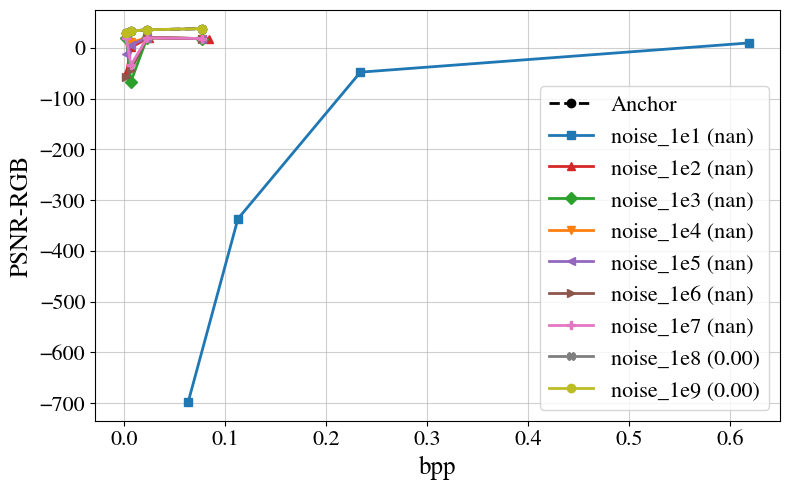

In [29]:
# colors = ['black', 'blue', 'orange', 'green', 'red', 'pink',]
colors = [
    "#000000",  # Preto -> linha de base / anchor
    "#1f77b4",  # Azul forte
    "#d62728",  # Vermelho científico
    "#2ca02c",  # Verde bem definido
    "#ff7f0e",  # Laranja destacado
    "#9467bd",  # Roxo sóbrio
    "#8c564b",  # Marrom científico
    "#e377c2",  # Rosa/magenta claro
    "#7f7f7f",  # Cinza neutro
    "#bcbd22"   # Amarelo mostarda
]

markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(8, 5))
plt.rcParams["font.family"] = "Nimbus Roman"


_, bpp_anchor, psnr_anchor = averages_by_rate(df_results, experiment="anchor", dataset=DATASET, frame_type=FRAME_TYPE)
plt.plot(
    bpp_anchor, psnr_anchor,
    label=f'Anchor',    
    linewidth=2,
    marker=markers[0],
    color=colors[0], linestyle='--',  # linha tracejada para o anchor
)


for i, exp in enumerate(TESTS_LABELS):    
    _, bpp, psnr = averages_by_rate(
        df_results,
        experiment=f"{exp}",
        frame_type=FRAME_TYPE,                        
        dataset=DATASET
    )

    try:
        bdbd = bd_rate(bpp_anchor, psnr_anchor, bpp, psnr, 'akima')
    except:
        bdbd = float("NaN")

    plt.plot(
        bpp, psnr,
        label=f'{exp} ({bdbd:.2f})',
        linewidth=2,
        marker=markers[(i+1)%len(markers)],
        color=colors[(i+1)%len(colors)],         
    )

plt.xlabel('bpp', fontsize=LABELS_FONTSIZE)
plt.ylabel('PSNR-RGB', fontsize=LABELS_FONTSIZE)
plt.legend(fontsize=LEGEND_FONTSIZE)   # aumenta a legenda
plt.tick_params(axis='both', labelsize=TICKS_FONTSIZE)  # aumenta os ticks dos eixos
plt.grid(True, linestyle='-', alpha=0.6)
# plt.xticks(np.arange(0, 0.4, 0.1))
# plt.yticks(np.arange(22, 37, 5))
# plt.xlim(0, 0.1)    # eixo X vai de 0 a 1.0
# plt.ylim(29, 36)    # eixo Y vai de 20 a 50
plt.tight_layout()   

# plt.savefig("/data/Ruhan/TCSVT2025/uniform_analysis.pdf", dpi=1200, bbox_inches="tight")   # formato PNG
